### Example Implementation
This file goes through every step of the process, using features available to HotDeckImputer.

In [333]:
# from hot_deck_imputer import HotDeckImputer
# Add the src directory to the Python path
import sys
import os

# Import the HotDeckImputer class
from hot_deck_imputer import HotDeckImputer
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Generate Data

In [334]:
# Create possibilities for race, sex, and work
race_categories = ['Black', 'White', 'Asian']
sex_categories = ['M', 'F']
work_categories = [0, 1]

np.random.seed(42)  # For reproducibility
# Generate polars frames
donor_data = {
    'donor_assets': np.random.randint(200, 500000, size=1000),
    'race_cell': np.random.choice(race_categories, size=1000),
    'sex_cell': np.random.choice(sex_categories, size=1000),
    'work_cell': np.random.choice(work_categories, size=1000),
    'weight': np.random.randint(1, 5, size=1000)
}

donor_data = pl.DataFrame(donor_data)

recipient_data = {
    'race_cell': np.random.choice(race_categories, size=1500),
    'sex_cell': np.random.choice(sex_categories, size=1500),
    'work_cell': np.random.choice(work_categories, size=1500),
    'weight': np.random.randint(1, 5, size=1500)
}

recipient_data = pl.DataFrame(recipient_data)

#### Create Imputer + Define Cells

In [335]:
imputer = HotDeckImputer(donor_data = donor_data, 
                         imputation_var = 'donor_assets', 
                         weight_var = 'weight', 
                         recipient_data = recipient_data,
                         random_seed = 42)

In [336]:
# If you are imputing from one dataset to another across years, this will adjust the donor data to the recipient year
imputer.age_dollar_amounts(donor_year_cpi = 223.1, imp_year_cpi = 322.1)

Summary of donor_assets pre CPI aging:
{'mean': 243894.595, 'median': 234681.5, 'min': 1215, 'max': 499816, 'std_dev': 145575.1328812389, 'count': 1000, 'missing_values': 0}
Summary of donor_assets post CPI aging:
{'mean': 352122.1382765577, 'median': 338820.7581801883, 'min': 1754.152846257284, 'max': 721607.9497982968, 'std_dev': 210173.6902781132, 'count': 1000, 'missing_values': 0}


In [337]:
# The variables create cells held in imputer.donor_cells, a dictionary.
# These cells divide the data according to every unique combination of the variables. 
# Key: combination of variables defining cell, Value: pl.DataFrame of data in that cell
variables = ['race_cell','sex_cell']

imputer.define_cells(variables)

# Take a look at cell definitions
imputer.cell_definitions

["race_cell == 'Asian' & sex_cell == 'M'",
 "race_cell == 'Asian' & sex_cell == 'F'",
 "race_cell == 'White' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'F'",
 "race_cell == 'Black' & sex_cell == 'M'",
 "race_cell == 'Black' & sex_cell == 'F'"]

In [338]:
# Create the cells after defining them, assuming above looks right
imputer.generate_cells()

In [339]:
# Take a look at the recipient cells
imputer.recipient_cells

{"race_cell == 'Asian' & sex_cell == 'M'": shape: (259, 4)
 ┌───────────┬──────────┬───────────┬────────┐
 │ race_cell ┆ sex_cell ┆ work_cell ┆ weight │
 │ ---       ┆ ---      ┆ ---       ┆ ---    │
 │ str       ┆ str      ┆ i32       ┆ i32    │
 ╞═══════════╪══════════╪═══════════╪════════╡
 │ Asian     ┆ M        ┆ 1         ┆ 3      │
 │ Asian     ┆ M        ┆ 0         ┆ 3      │
 │ Asian     ┆ M        ┆ 0         ┆ 1      │
 │ Asian     ┆ M        ┆ 1         ┆ 2      │
 │ Asian     ┆ M        ┆ 1         ┆ 2      │
 │ …         ┆ …        ┆ …         ┆ …      │
 │ Asian     ┆ M        ┆ 1         ┆ 3      │
 │ Asian     ┆ M        ┆ 0         ┆ 2      │
 │ Asian     ┆ M        ┆ 0         ┆ 2      │
 │ Asian     ┆ M        ┆ 1         ┆ 2      │
 │ Asian     ┆ M        ┆ 1         ┆ 1      │
 └───────────┴──────────┴───────────┴────────┘,
 "race_cell == 'Asian' & sex_cell == 'F'": shape: (241, 4)
 ┌───────────┬──────────┬───────────┬────────┐
 │ race_cell ┆ sex_cell ┆ work_cell

In [340]:
# Take a look at donor cells
imputer.donor_cells

{"race_cell == 'Asian' & sex_cell == 'M'": shape: (162, 5)
 ┌───────────────┬───────────┬──────────┬───────────┬────────┐
 │ donor_assets  ┆ race_cell ┆ sex_cell ┆ work_cell ┆ weight │
 │ ---           ┆ ---       ┆ ---      ┆ ---       ┆ ---    │
 │ f64           ┆ str       ┆ str      ┆ i32       ┆ i32    │
 ╞═══════════════╪═══════════╪══════════╪═══════════╪════════╡
 │ 190765.204841 ┆ Asian     ┆ M        ┆ 1         ┆ 2      │
 │ 173363.719857 ┆ Asian     ┆ M        ┆ 1         ┆ 1      │
 │ 126613.74182  ┆ Asian     ┆ M        ┆ 0         ┆ 4      │
 │ 541507.705513 ┆ Asian     ┆ M        ┆ 1         ┆ 3      │
 │ 267062.913043 ┆ Asian     ┆ M        ┆ 1         ┆ 1      │
 │ …             ┆ …         ┆ …        ┆ …         ┆ …      │
 │ 717086.133572 ┆ Asian     ┆ M        ┆ 1         ┆ 4      │
 │ 576241.375616 ┆ Asian     ┆ M        ┆ 0         ┆ 3      │
 │ 145381.011654 ┆ Asian     ┆ M        ┆ 0         ┆ 2      │
 │ 351012.481398 ┆ Asian     ┆ M        ┆ 1         ┆ 1    

In [341]:
# After deciding that you want to split on work_cell for Black Women, you can do the following
imputer.split_cell("race_cell == 'Black' & sex_cell == 'F'", "work_cell")
imputer.split_cell("race_cell == 'White' & sex_cell == 'F'", "work_cell")


Cell splitting completed successfully.
To rerun with these cells submit imputer.impute() again.
Cell splitting completed successfully.
To rerun with these cells submit imputer.impute() again.


In [342]:
# Cell definitions have changed, as have donor cells
imputer.cell_definitions

["race_cell == 'Asian' & sex_cell == 'M'",
 "race_cell == 'Asian' & sex_cell == 'F'",
 "race_cell == 'White' & sex_cell == 'M'",
 "race_cell == 'Black' & sex_cell == 'M'",
 "race_cell == 'Black' & sex_cell == 'F' & work_cell == 1",
 "race_cell == 'Black' & sex_cell == 'F' & work_cell == 0",
 "race_cell == 'White' & sex_cell == 'F' & work_cell == 0",
 "race_cell == 'White' & sex_cell == 'F' & work_cell == 1"]

In [343]:
# Take a look at donor and recipient after splitting
imputer.donor_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 1"]

donor_assets,race_cell,sex_cell,work_cell,weight
f64,str,str,i32,i32
79530.25818,"""Black""","""F""",1,4
561138.336172,"""Black""","""F""",1,2
609418.686239,"""Black""","""F""",1,4
373923.305693,"""Black""","""F""",1,4
4254.722994,"""Black""","""F""",1,1
…,…,…,…,…
458574.535186,"""Black""","""F""",1,4
518811.999552,"""Black""","""F""",1,4
71619.967279,"""Black""","""F""",1,4


In [344]:
imputer.recipient_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 1"]

race_cell,sex_cell,work_cell,weight
str,str,i32,i32
"""Black""","""F""",1,1
"""Black""","""F""",1,1
"""Black""","""F""",1,4
"""Black""","""F""",1,3
"""Black""","""F""",1,4
…,…,…,…
"""Black""","""F""",1,4
"""Black""","""F""",1,4
"""Black""","""F""",1,3


In [345]:
imputer.recipient_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 0"]

race_cell,sex_cell,work_cell,weight
str,str,i32,i32
"""Black""","""F""",0,1
"""Black""","""F""",0,1
"""Black""","""F""",0,3
"""Black""","""F""",0,1
"""Black""","""F""",0,2
…,…,…,…
"""Black""","""F""",0,1
"""Black""","""F""",0,2
"""Black""","""F""",0,2


In [346]:
# Collapse cell for White and Black folks back to original, without work
imputer.collapse_cell("race_cell == 'Black' & sex_cell == 'F'")
imputer.collapse_cell("race_cell == 'Black' & sex_cell == 'M'")
imputer.collapse_cell("race_cell == 'White' & sex_cell == 'F'")
imputer.collapse_cell("race_cell == 'White' & sex_cell == 'M'")

imputer.cell_definitions

Cell collapsing completed successfully.
To rerun with these cells submit imputer.impute() again.
Cell collapsing completed successfully.
To rerun with these cells submit imputer.impute() again.
Cell collapsing completed successfully.
To rerun with these cells submit imputer.impute() again.
Cell collapsing completed successfully.
To rerun with these cells submit imputer.impute() again.


["race_cell == 'Asian' & sex_cell == 'M'",
 "race_cell == 'Asian' & sex_cell == 'F'",
 "race_cell == 'Black' & sex_cell == 'F'",
 "race_cell == 'Black' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'F'",
 "race_cell == 'White' & sex_cell == 'M'"]

#### Impute Data + Apply Smoothing

In [347]:
imputer.impute()

In [348]:
# Notice imp_donor_assets has been added to recipient cells
imputer.recipient_cells

{"race_cell == 'Asian' & sex_cell == 'M'": shape: (259, 5)
 ┌───────────┬──────────┬───────────┬────────┬──────────────────┐
 │ race_cell ┆ sex_cell ┆ work_cell ┆ weight ┆ imp_donor_assets │
 │ ---       ┆ ---      ┆ ---       ┆ ---    ┆ ---              │
 │ str       ┆ str      ┆ i32       ┆ i32    ┆ f64              │
 ╞═══════════╪══════════╪═══════════╪════════╪══════════════════╡
 │ Asian     ┆ M        ┆ 1         ┆ 3      ┆ 451101.699686    │
 │ Asian     ┆ M        ┆ 0         ┆ 3      ┆ 550789.556253    │
 │ Asian     ┆ M        ┆ 0         ┆ 1      ┆ 11178.934558     │
 │ Asian     ┆ M        ┆ 1         ┆ 2      ┆ 136688.209771    │
 │ Asian     ┆ M        ┆ 1         ┆ 2      ┆ 707104.065442    │
 │ …         ┆ …        ┆ …         ┆ …      ┆ …                │
 │ Asian     ┆ M        ┆ 1         ┆ 3      ┆ 309279.524877    │
 │ Asian     ┆ M        ┆ 0         ┆ 2      ┆ 180557.912147    │
 │ Asian     ┆ M        ┆ 0         ┆ 2      ┆ 249338.028687    │
 │ Asian     ┆ M 

In [349]:
imputer.recipient_data

race_cell,sex_cell,work_cell,weight,imp_donor_assets
str,str,i32,i32,f64
"""Asian""","""M""",1,3,451101.699686
"""Asian""","""M""",0,3,550789.556253
"""Asian""","""M""",0,1,11178.934558
"""Asian""","""M""",1,2,136688.209771
"""Asian""","""M""",1,2,707104.065442
…,…,…,…,…
"""White""","""M""",1,4,208110.383684
"""White""","""M""",1,2,13784.898252
"""White""","""M""",0,3,604352.57732


In [350]:
# To smooth out clusters, you can add random noise proportional to the standard deviation of the variable 
# and set a floor value that the noise cannot send a value below (to avoid negative or impossible values)
imputer.apply_random_noise(variation_stdev = (1/6), floor_noise = 1.5)

In [351]:
# Take a look at the random noise used, initialized after above function is called
imputer.random_noise

0.16666666666666666

#### Examine Results

In [352]:
imputer.donor_data.columns

['donor_assets', 'race_cell', 'sex_cell', 'work_cell', 'weight']

In [353]:
imputer.summarize_column(imputer.donor_data, 'donor_assets')

{'mean': 352122.1382765577,
 'median': 338820.7581801883,
 'min': 1754.152846257284,
 'max': 721607.9497982968,
 'std_dev': 210173.6902781132,
 'count': 1000,
 'missing_values': 0}

In [354]:
imputer.summarize_column(imputer.recipient_data, 'imp_donor_assets')

{'mean': 356183.56830284355,
 'median': 346654.14367920253,
 'min': 2083.449215133658,
 'max': 721348.5039757363,
 'std_dev': 208889.3052314998,
 'count': 1500,
 'missing_values': 0}

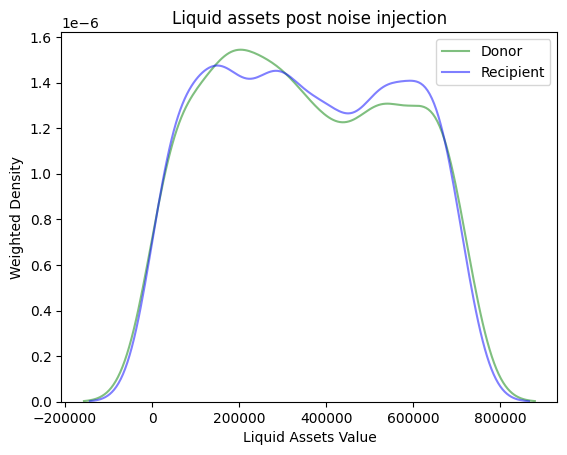

In [355]:
# Compare the input to the output in the process
plot_data = imputer.recipient_data[['weight','imp_donor_assets']]
plot_data_donor = imputer.donor_data[['weight','donor_assets']]

# Create a weighted histogram plot for donor data
sns.kdeplot(data=plot_data_donor, x='donor_assets', weights='weight', color='green', label='Donor', alpha=0.5)

# Create a weighted histogram plot for recipient data
sns.kdeplot(data=plot_data, x='imp_donor_assets', weights='weight', color='blue', label='Recipient', alpha=0.5)

# Add titles and labels
plt.title('Liquid assets post noise injection')
plt.xlabel('Liquid Assets Value')
plt.ylabel('Weighted Density')

# Add a legend to differentiate between recipient and donor data
plt.legend()

# Show the plot
plt.show()

In [48]:
imputer.gen_analysis_file('hot_deck_stats', '')

Cell data written to '.\hot_deck_stats.xlsx'.
